# DeepFake Detection with MesoNet 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [31]:
# hight and wedith refer to the size of the image 
# channels refer to the amount of color
image_dimensions ={'height': 256, 'width':256, 'channels': 3}

In [32]:
# creat classifier class
class Classifier:
    def __init__():
        self.model = 0
        
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x,y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x,y)
    
    def load(self, path):
        self.model.load_weights(path)
        
    
    

In [33]:
# creat MesoNet class using the classifer

class Meso4(Classifier):
    def __init__(self, learning_rate= 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, 
                           loss = 'mean_squared_error', 
                           metrics = [' accuracy'])
        
    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        x1 = Conv2D(8, (3,3), padding = 'same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size= (2, 2), padding = 'same')(x1)
        
        x2 = Conv2D(8, (5,5), padding = 'same', activation = 'relu')(x1)
        x2= BatchNormalization()(x2)
        x2= MaxPooling2D(pool_size= (2, 2), padding = 'same')(x2)
        
        
        x3= Conv2D(16, (5,5), padding = 'same', activation = 'relu')(x2)
        x3= BatchNormalization()(x3)
        x3= MaxPooling2D(pool_size= (2, 2), padding = 'same')(x3)
        
        x4= Conv2D(16 , (5,5), padding = 'same', activation = 'relu')(x3)
        x4= BatchNormalization()(x4)
        x4= MaxPooling2D(pool_size= (4, 4), padding = 'same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        
        
        return Model(inputs=x, outputs =y)

In [34]:
# instantiate a MesoNet with pretrained weights 

meso = Meso4()
meso.load('Meso4_DF')

2023-10-30 22:37:36.046105: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open Meso4_DF: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [35]:
# prepare image data

# rescaling pixel values (between 1, 255)
dataGenerator = ImageDataGenerator(rescale = 1./255)

# instantiating generator to feed imagr through the network

generator = dataGenerator.flow_from_directory('archive/data/train', target_size=(256,256), batch_size= 1, class_mode= 'binary') 


Found 6895 images belonging to 2 classes.


In [36]:
# checking class assignment 

generator.class_indices


{'fake': 0, 'real': 1}

1/1 [==============================] - 0s 56ms/step
Predicted likelihood: 0.8920
Actual label: 0
1/1 [==============================] - 0s 12ms/step

Correct predication: False


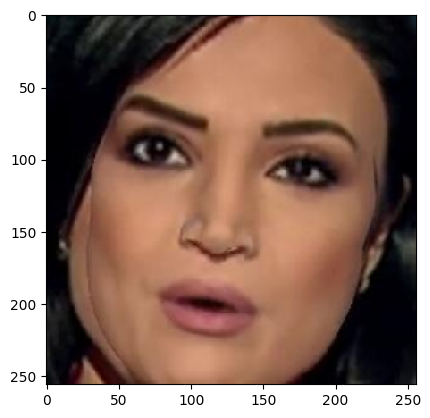

In [37]:
#Rendering image X with label y for MesoNet

X, y = generator.next()

# Evaluating predication 
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect predication: {round(meso.predict(X)[0][0])==y[0]}")
plt.imshow(np.squeeze(X));

In [38]:
# creating separate lists for correctly classified and misclassified images
# two lists for each category one for store the image data and the second store prediction value 
correct_real = [] 
correct_real_pred = [] 

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []


### Generating predictions on validation set, starting in separate lists


In [39]:
### Generating predictions on validation set, starting in separate lists

for i in range(len(generator.labels)):
    #loading next pict
    X, y = generator.next()
    
    if round(meso.predict(X)[0][0])==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(meso.predict(X)[0][0])
        
    elif round (meso.predict(X)[0][0])==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(meso.predict(X)[0][0])
    
    elif round (meso.predict(X)[0][0])!=y[0] and y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(meso.predict(X)[0][0])
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(meso.predict(X)[0][0])
    
    if i % 1000 == 0:
        print(i, "predictions completed.")
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels),"predictions completed.")
                

1/1 [==============================] - 0s 15ms/step
0 predictions completed.
1/1 [==============================] - 0s 15ms/step
1000 predictions completed.
1/1 [==============================] - 0s 14ms/step
2000 predictions completed.
1/1 [==============================] - 0s 15ms/step
3000 predictions completed.
1/1 [==============================] - 0s 16ms/step
4000 predictions completed.
1/1 [==============================] - 0s 16ms/step
5000 predictions completed.
1/1 [==============================] - 0s 20ms/step
6000 predictions completed.
1/1 [==============================] - 0s 15ms/step
All 6895 predictions completed.


In [45]:
def plotter(image, preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(image)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4, i+1)
        plt.imshow(np.squeeze(image[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax =plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

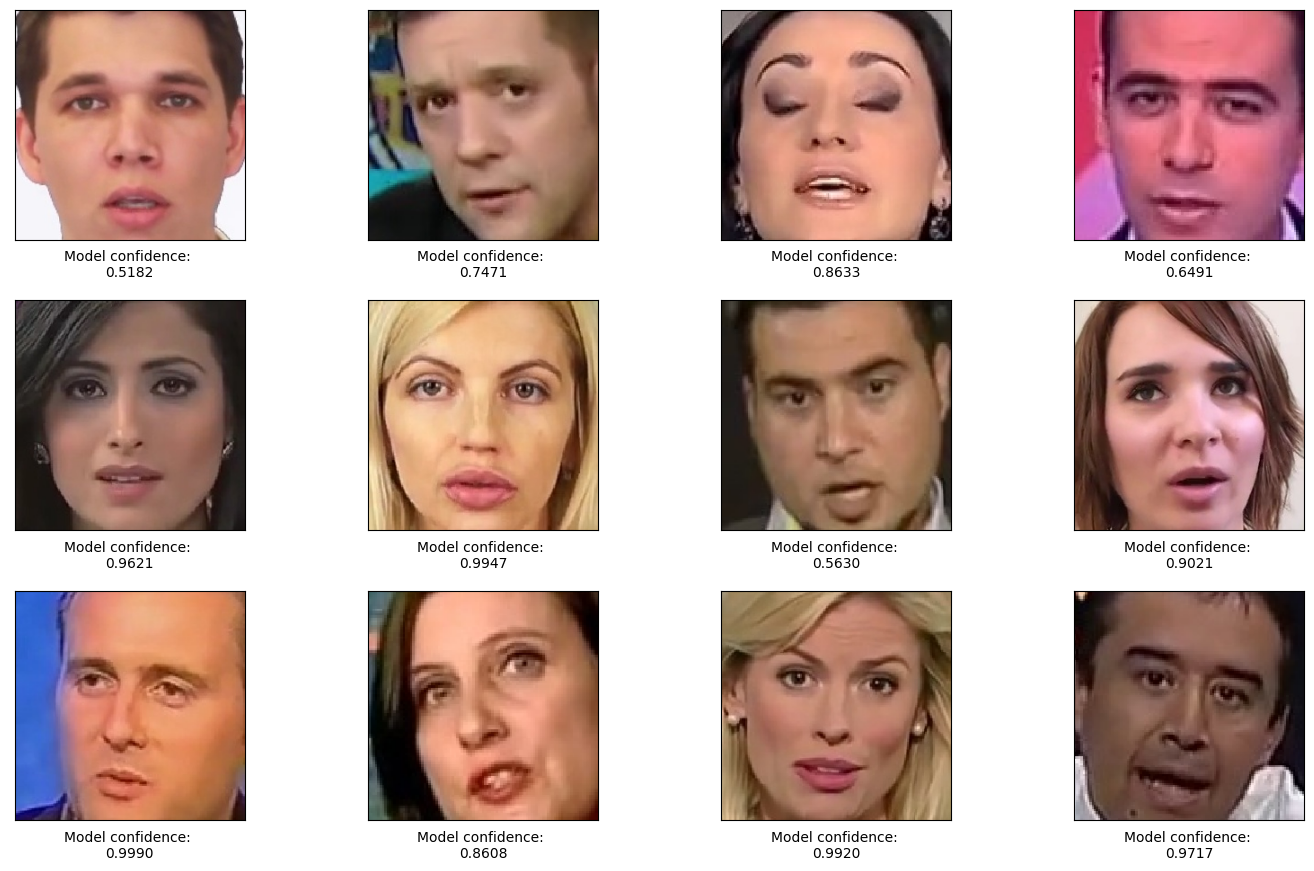

In [46]:
plotter(correct_real, correct_real_pred)

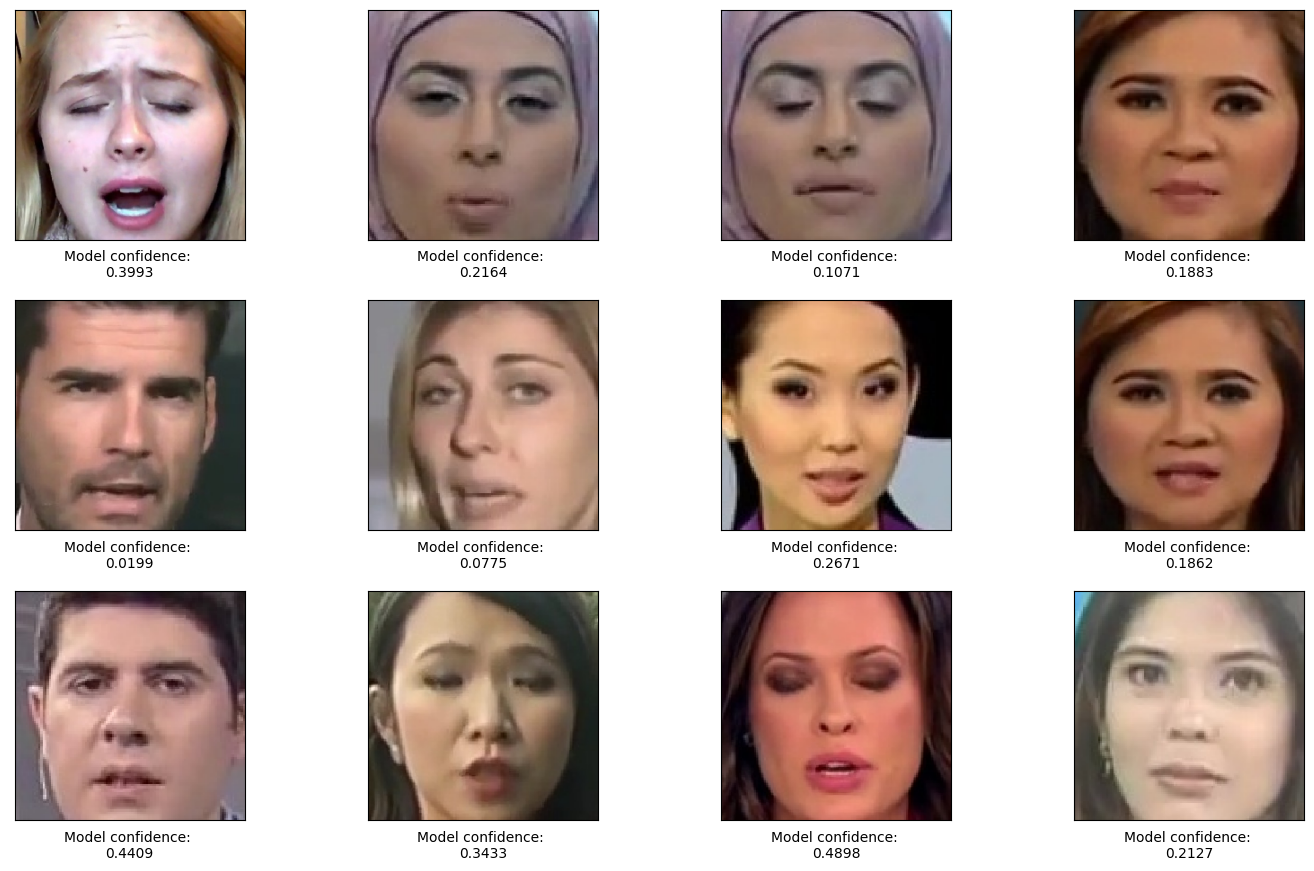

In [42]:
plotter(misclassified_real, misclassified_real_pred)

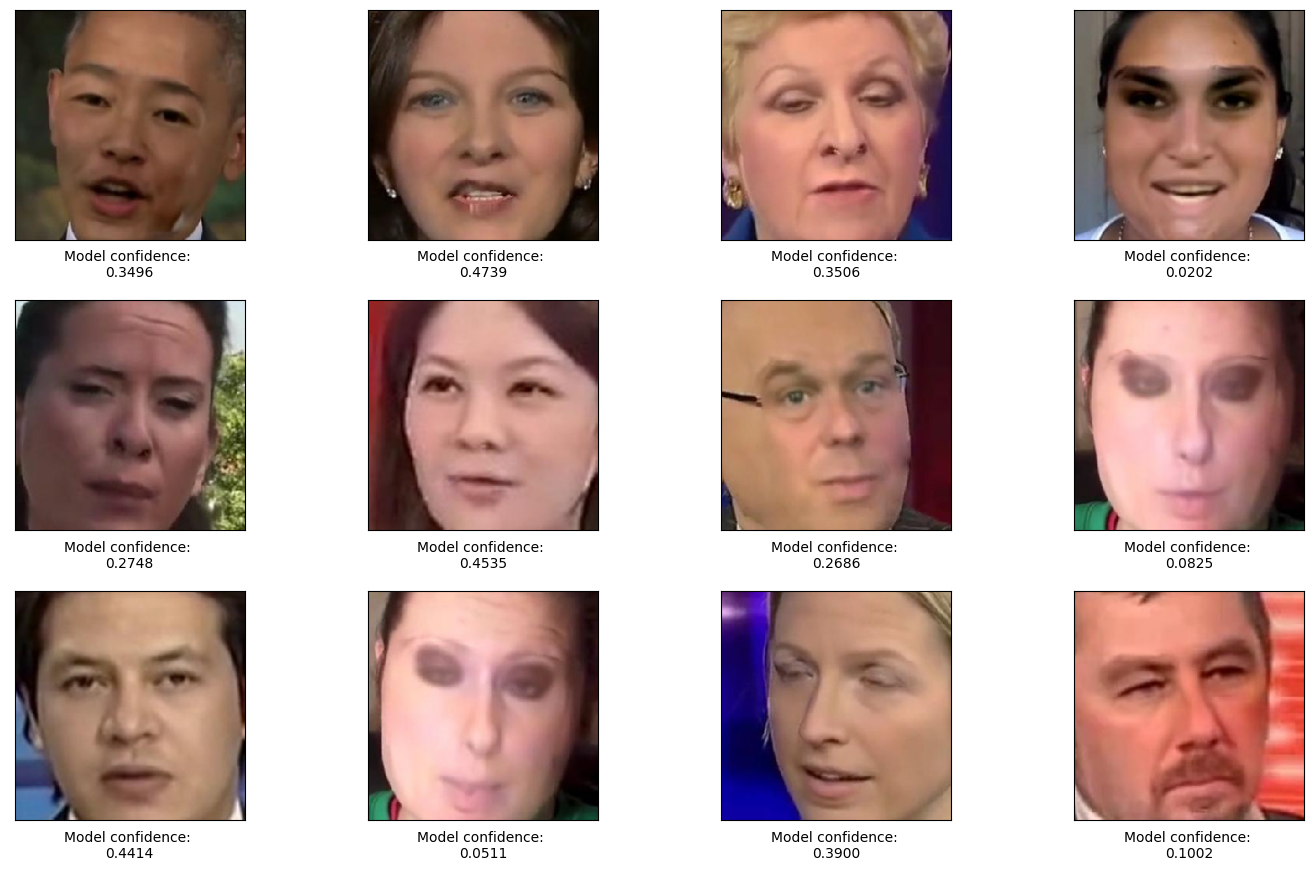

In [43]:
plotter(correct_deepfake, correct_deepfake_pred)

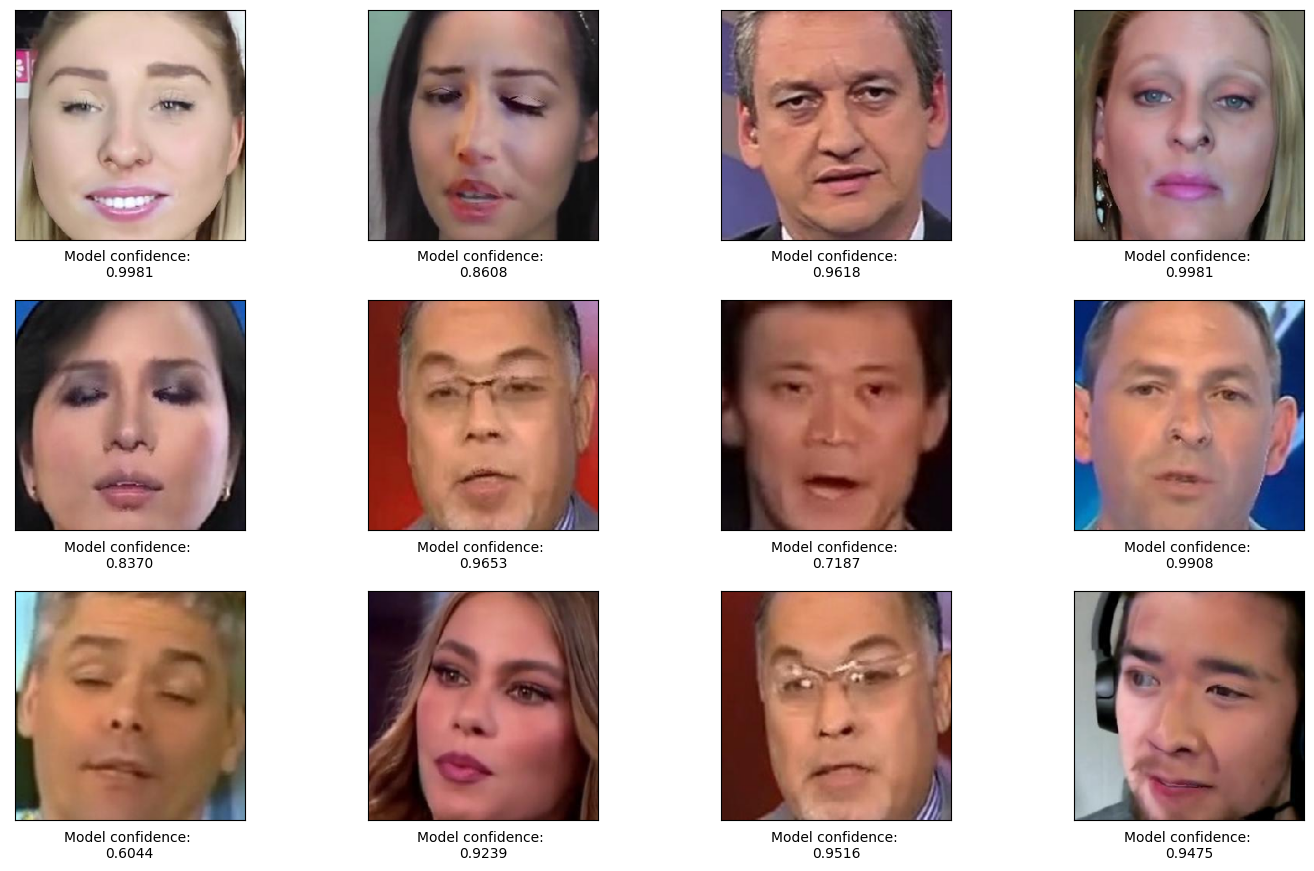

In [44]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)